# Linear regression

## En esta parte, voy a ir describiendo el proceso y los pasos necesarios para construir un riguroso modelo de Regresion Lineal que nos permita predecir los valores de la futura temperatura media diaria basandonos en el dataSet que ya tenemos preparado
## Usare dos de las librerias mas importantes de python para la industria del Machine Learning: Scikit-Learn y StatsModels 

### Abrimos el dataframe exportado de la primera parte

In [1]:
import pickle
with open('end-part1_df.pkl', 'rb') as fp:
    df = pickle.load(fp)

### Utilizaremos un modelo de regresion lineal con el algoritmo de MCO (minimos cuadrados ordinarios)

[Informacion sobre que es la regresion lineal](https://es.wikipedia.org/wiki/Regresi%C3%B3n_lineal)

[Informacion sobre el método utilizado para encontrar los parámetros poblacionales en un modelo de regresión lineal](https://es.wikipedia.org/wiki/M%C3%ADnimos_cuadrados_ordinarios)

QUIZA dar mas explicaciones de la regresion y su algoritmo

## Eligiendo las caracteristicas de nuestro modelo

#### Un punto clave que se asume cuando se utiliza la tecnica de regresion lineal es que tenemos una relacion lineal entre la variable dependiente y cada una de las variables independientes

#### Una forma de comprobar la linealidad entre nuestra variable independiente, que sera la TEMPERATURA MEDIA y las otras variables independientes, consiste en calcula el [coeficiente de correlacion de Pearson](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson) 

#### La siguiente tabla indica como se interpreta el coeficiente:



| Correlation Value | Interpretation |
| -- | -- |
| 0.8 - 1.0 | Very Strong |
| 0.6 - 0.8| Strong |
| 0.4 - 0.6 | Moderate |
| 0.2 - 0.4 | Weak |
| 0.0 - 0.2 | Very weak |



#### Para obtener la correlacion de nuestro dataSet, utilizaremos el metodo ` corr()`  de Pandas DataFRame Object. Le pasaremos la columna en la que estamos interesados, que en este caso es 'tmed' y despues ordenamos el resultado desde los menos correlacionados a los mascorrelacionados

In [2]:
df.corr()[['tmed']].sort_values('tmed')

,tmed
prec_1,-0.131943
prec_2,-0.121593
prec_3,-0.109075
tmin_3,0.866754
tmin_2,0.884268
tmax_3,0.901946
tmin_1,0.915285
tmed_3,0.918337
tmax_2,0.919749
tmed_2,0.936532


#### A partir de estos resultados, he decidido eliminar las variables que tengan el coeficiente de correlacion menor que 0.6 y tambien tmed ya que teniendo para el dia tmax y tmin, voy a buscar predecir tmed. En este caso mantendre tmed, para tener un array cuadrado, pero saldra una linea recta en las graficas de abajo

#### Creo el nuevo dataframe:

In [3]:
df2 = df.drop(['prec_1', 'prec_2', 'prec_3'], axis=1)
predictors = ['tmin','tmax','tmed_1','tmed_2','tmed_3','tmin_1','tmin_2','tmin_3','tmax_1','tmax_2', 'tmax_3', 'tmed']

## Visualizando las relaciones

#### Mediante matplotlib voy a dibujar las variables que usare para la prediccion, para comprobar visualmente de que existe una relacion lineal

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#### Voy a colocar la variable dependiente tmed en el eje Y y las otras 11 variables sobre el eje X.

#### Además hare una estructura de cuadrados para que se vea mas claramente

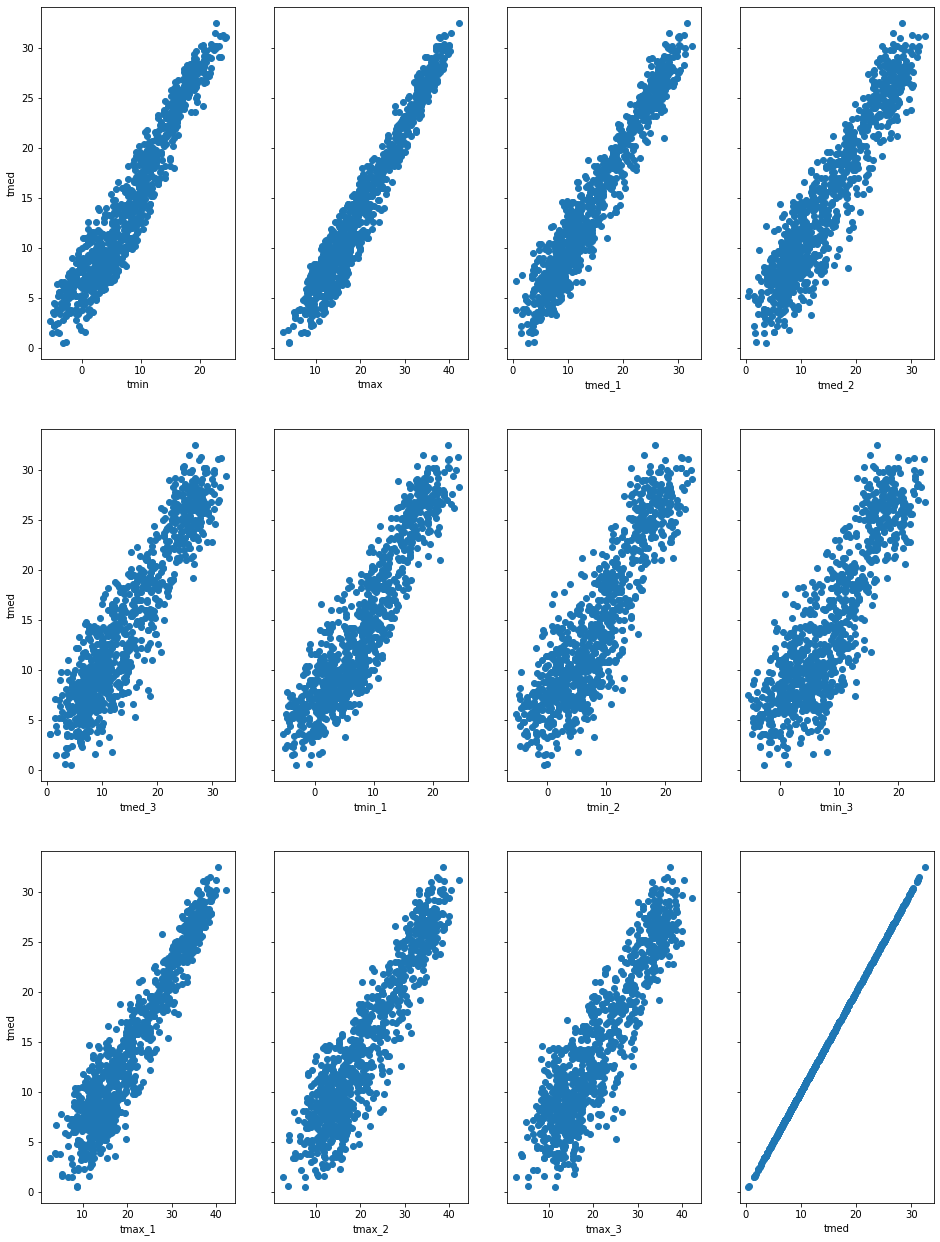

In [5]:
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [16, 22]

# call subplots specifying the grid structure we desire and that 
# the y axes should be shared
fig, axes = plt.subplots(nrows=3, ncols=4, sharey=True)

# Since it would be nice to loop through the features in to build this plot
# let us rearrange our data into a 2D array of 6 rows and 3 columns
arr = np.array(predictors).reshape(3, 4)

# use enumerate to loop over the arr 2D array of rows and columns
# and create scatter plots of each meantempm vs each feature
for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2['tmed'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='tmed')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

#### Observando las graficas, se puede observar como las variables de prediccion muestran una buena relacion lineal con la variable a predercir, tmed

#### Ademas se puede observar .....

In [6]:
#Quito ya el tmed de predictors
predictors = ['tmin','tmax','tmed_1','tmed_2','tmed_3','tmin_1','tmin_2','tmin_3','tmax_1','tmax_2', 'tmax_3']

## Usando regresion gradual para construir un modelo robusto

#### Un modelo de regresion lineal robusto debe utilizar test estadisticos para seleccionar los indicadores significativos.

#### Para seleccionar las caracteristicas estadisticas, utilizare la libreria de python `statsmodels`.

#### Antes de continuar con la practica, voy a hablar un poco de teoria.
#### Un punto muy importante a la hora de trabajar con regresion lineal, es la valided y correcion de las hipotesis que se hacen sobre los datos a estudiar. Una forma de comprobar estas hipotesis es evaluando la importancia de cada una de las variables incluidas en la prediccion. TODO: ver si ampliar
#### De este modo, seleccionariamos de manera mucho mas minuciosa las variables a incluir y obtendriamos un modelo mas robusto

#### Aun asi, en muchos datasets puede haber interacciones  que ocurren entre variables que den lugar a falsas interpretaciones en estos simples test de hipotesis.

#### Por ello, para testear si son significativos los efectos de las interacciones de cada una de las variables en un modelo de regresion, se utiliza la [regresion gradual o progresiva](https://en.wikipedia.org/wiki/Stepwise_regression#:~:text=In%20statistics%2C%20stepwise%20regression%20is,based%20on%20some%20prespecified%20criterion.). Esta nos permite ir añadiendo o eliminando variables del modelo e ir validando si hay importancia estadistica de cada una de las variables en el modelo resultante.

#### Comienzo ya con la parte practica, para aplicar lo explicado mediante `statsmodels`

In [9]:
# Importamos el modulo
import statsmodels.api as sm

# Separo mis variables de prediccion (X) de mi variable de resultado Y
X = df2[predictors]
y = df2['tmed']

#Añadimos una constante al conjunto de variables de prediccion para representar como de importante es la interseccion
# Add a constant to the predictor variable set to represent the Bo intercept
X = sm.add_constant(X)
X.iloc[:5, :5]

,const,tmin,tmax,tmed_1,tmed_2
fecha,,,,,
2018-01-04,1.0,7.9,15.6,11.2,10.4
2018-01-05,1.0,5.2,10.4,11.8,11.2
2018-01-06,1.0,1.3,5.3,7.8,11.8
2018-01-07,1.0,-0.1,3.8,3.3,7.8
2018-01-08,1.0,-1.0,8.8,1.8,3.3


In [10]:
# (1) select a significance value
alpha = 0.05

# (2) Fit the model
model = sm.OLS(y, X).fit()

# (3) evaluate the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   tmed   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.064e+06
Date:                Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                        21:52:07   Log-Likelihood:                 1770.8
No. Observations:                 912   AIC:                            -3518.
Df Residuals:                     900   BIC:                            -3460.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.004      0.687      0.492      -0.005       0.010
tmin           0.5010      0.001    967.705      0.000       0.500       0.502
tmax           0.4998      0.000   1161.779      0.000       0.499       0.501
tmed_1        -0.0014      0.033     -0.043      0.966      -0.067       0.064
tmed_2        -0.0151      0.033     -0.455      0.649      -0.080       0.050
tmed_3         0.0256      0.033      0.772      0.440      -0.039       0.091
tmin_1         0.0008      0.017      0.048      0.962      -0.032       0.034
tmin_2         0.0076      0.017      0.459      0.646      -0.025       0.040
tmin_3        -0.0138      0.017     -0.832      0.406      -0.046       0.019
tmax_1         0.0006      0.017      0.034      0.973      -0.032       0.033
tmax_2         0.0078      0.017      0.467      0.641      -0.025       0.040
tmax_3        -0.0128      0.017     -0.775      0.439      -0.045       0.020
==============================================================================
Omnibus:                      135.123   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.760
Skew:                           0.015   Prob(JB):                     7.70e-08
Kurtosis:                       2.072   Cond. No.                     2.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""